**Bike Network Metric Generation**

This notebook is used to perform basic analysis of both the bike network and wider underlying street network. It requires the prior notebook (00-bike-network-data-collection.ipynb) to have been run to collect the street networks from OpenStreetMap.

In [1]:
# libary imports
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import os
import networkx as nx
import momepy
import pandas as pd
import numpy as np

# get working directory
working_directory =  os.getcwd()


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\pyproj\__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get street networks

bike_network = ox.io.load_graphml(working_directory + "\data\\bike_network.xml")

road_network =  ox.io.load_graphml(working_directory + "\data\\road_network.xml")

# get area boundary 

boundary = gpd.read_file(working_directory + "\data\\boundary.gpkg")

# get place from script 00

%store -r place

# get fast_mode from script 00

%store -r fast_mode


In [3]:
# convert graphs to gdfs

bike_network_edges = ox.utils_graph.graph_to_gdfs(bike_network, nodes=False)

road_network_edges = ox.utils_graph.graph_to_gdfs(road_network, nodes=False)

In [4]:
# create undirected graphs with bearings

bike_network_undirected = ox.add_edge_bearings(ox.utils_graph.get_undirected(bike_network))

road_network_undirected = ox.add_edge_bearings(ox.utils_graph.get_undirected(road_network))

In [5]:
# calculate lenghts of streets

bike_length = (bike_network_edges['length'].sum())* 0.0001 # convert to km

road_length = (road_network_edges['length'].sum())* 0.0001 # convert to km


# save to Dataframe

lengths_df = gpd.GeoDataFrame([road_length, bike_length])

row_names = {0:'Road',
            1:'Bike Paths'}

lengths_df = lengths_df.rename(index = row_names)


(array([0, 1]), [Text(0, 0, 'Road'), Text(1, 0, 'Bike Paths')])

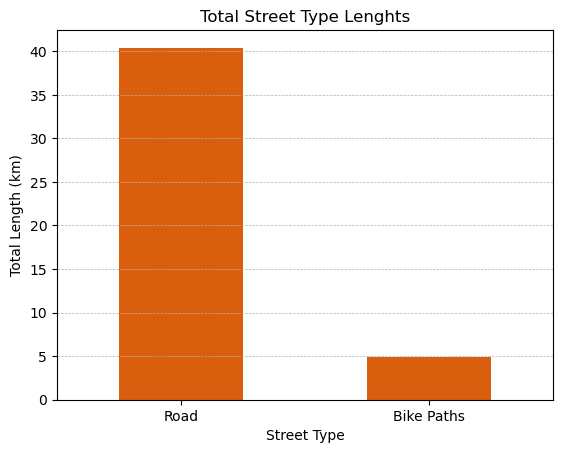

In [6]:
# plot street lenghts

colours = ['#d95f0e', '#fec44f']
ax = lengths_df.plot.bar(color=colours)
ax.set_xlabel("Street Type")
ax.set_ylabel("Total Length (km)")
ax.get_legend().remove()
plt.title("Total Street Type Lenghts")
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0)

In [7]:
# calculate the ratio of road compared to bike streets

def ratioFunction(input1, input2):
    num1 = input1
    num1 = float(num1) 
    num2 = input2
    num2 = float(num2) 
    ratio12 = float(num1/num2)
    print('The ratio of road network (', num1, 'km) to bike network (', num2,'km) is 1 :', str(ratio12) + '.')
    return(ratio12)

road_to_bike_ratio = ratioFunction(road_length, bike_length)

The ratio of road network ( 40.405622300000005 km) to bike network ( 4.9517728 km) is 1 : 8.159829606883418.


In [8]:
# calculate number of disconnected components

bike_components = nx.number_connected_components(bike_network_undirected)
road_components = nx.number_connected_components(road_network_undirected)

In [9]:
# THIS MAY NEED CHANGING
# calculate the mean level of disconnect

mean_level_of_disconnect = bike_components/bike_length 

print(mean_level_of_disconnect)

9.087654425501913


In [10]:
# find the total number of intersections 

bike_intersections = bike_network.number_of_nodes()

road_intersections = road_network.number_of_nodes()

In [11]:
# measure entropy

bike_entropy = ox.bearing.orientation_entropy(bike_network_undirected)
road_entropy = ox.bearing.orientation_entropy(road_network_undirected)

Bike network entropy is:  3.4450481853560055


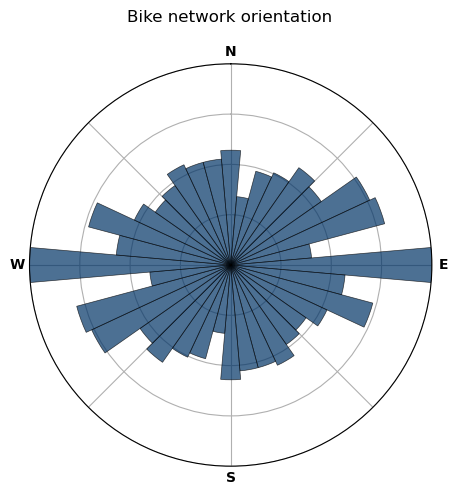

In [12]:
# plot bike network orientation

fig, ax = ox.bearing.plot_orientation(bike_network_undirected)

fig.suptitle("Bike network orientation")
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
print("Bike network entropy is: ", bike_entropy)

# the maximum entropy equals the logarithm of the number of bins: 3.584
# the minimum theoretical entropy is 0.693 (North-South only)
# the minimum realistic entropy is 1.386 (perfect North-South-East-West grid)

Road network entropy is:  3.5547782598863074


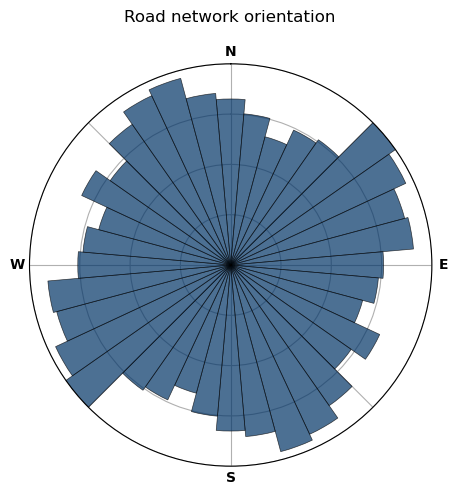

In [13]:
# measure road network orientation

fig, ax = ox.bearing.plot_orientation(road_network_undirected)

fig.suptitle("Road network orientation")
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
print("Road network entropy is: ", road_entropy)

# the maximum entropy equals the logarithm of the number of bins: 3.584
# the minimum theoretical entropy is 0.693 (North-South only)
# the minimum realistic entropy is 1.386 (perfect North-South-East-West grid)

u            v            key
364811       364814       0      321.4
             7761408      0      167.5
             4336198950   0       74.8
364814       364815       0      343.6
             364914       0      238.8
                                 ...  
10073260116  10073260119  0       47.4
10073261059  10073261060  0      200.0
10272990585  10272990587  0       90.3
10272990586  10272990587  0      270.3
10272990587  10272990588  0      358.1
Name: bearing, Length: 2889, dtype: float64

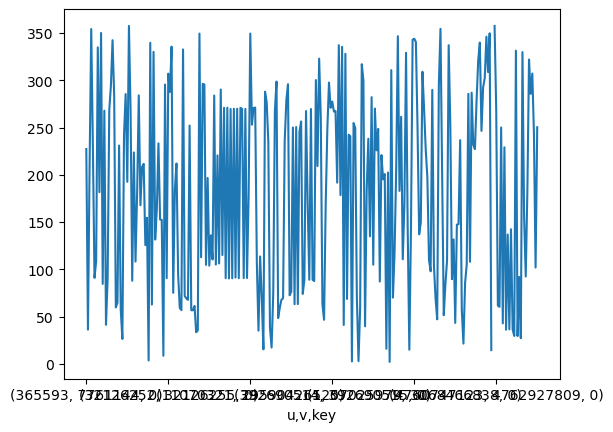

In [14]:
# TO DO
# want to compare these two plots somehow, find a level of differance between

# can turn u-graph to gdf to access bearing of every edge

bike_network_undirected_gdf = ox.utils_graph.graph_to_gdfs(bike_network_undirected, nodes=False)

road_network_undirected_gdf = ox.utils_graph.graph_to_gdfs(road_network_undirected, nodes=False)


bike_network_undirected_gdf['bearing'].plot()
road_network_undirected_gdf['bearing']

In [15]:
# calculate network stats

# boundary area is required for the ox.basic_stats function

# calculate boundary area

area = boundary.unary_union.area

# with area found, the ox.basic_stats function can be used to calculate a host of useful stats

bike_stats = ox.basic_stats(bike_network, area=area)

road_stats = ox.basic_stats(road_network, area=area)

# unpack the dictionaries of node countes and node proportions into series

for k, count in bike_stats["streets_per_node_counts"].items():
    bike_stats["{}way_int_count".format(k)] = count
for k, count in bike_stats["streets_per_node_proportions"].items():
    bike_stats["{}way_int_prop".format(k)] = count

for k, count in road_stats["streets_per_node_counts"].items():
    road_stats["{}way_int_count".format(k)] = count
for k, count in road_stats["streets_per_node_proportions"].items():
    road_stats["{}way_int_prop".format(k)] = count

# convert to dataframe and rename index column

bike_stats = pd.DataFrame(pd.Series(bike_stats, name="bike_values"))
bike_stats.index.names = ['metric']

road_stats = pd.DataFrame(pd.Series(road_stats, name="road_values"))
road_stats.index.names = ['metric']

# join dataframes

stats = bike_stats.join(road_stats, on='metric')

c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\shape.py:1252: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length


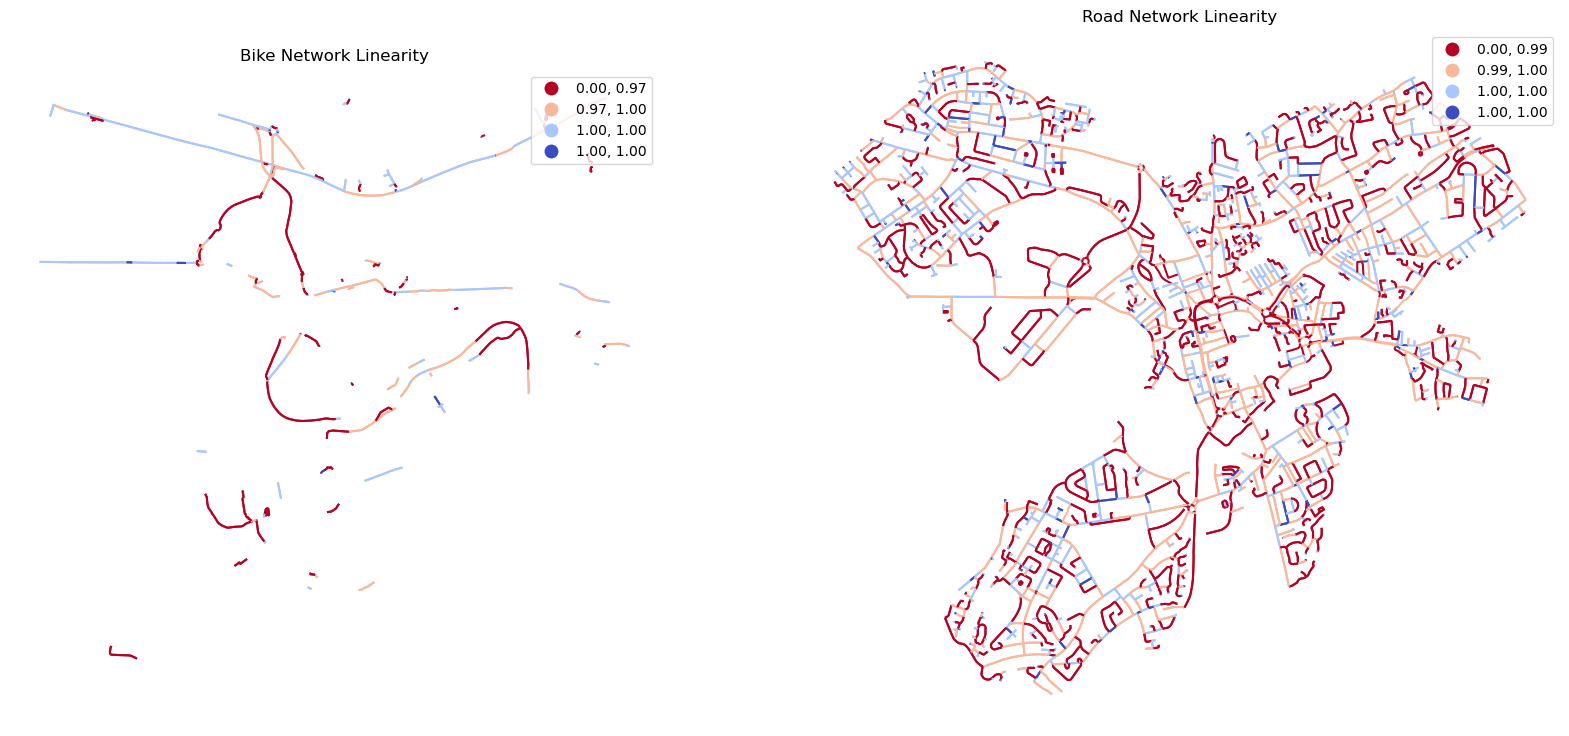

In [16]:
# calculate linearity

bike_network_lin = momepy.Linearity(bike_network_edges)
bike_network_edges['linearity'] = bike_network_lin.series

road_network_lin = momepy.Linearity(road_network_edges)
road_network_edges['linearity'] = road_network_lin.series

# plot linearity

f, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1.171]})
f.set_figheight(20)
f.set_figwidth(20)
road_network_edges.plot(column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4, ax=ax[1])
bike_network_edges.plot(column='linearity', legend=True, cmap='coolwarm_r', scheme='quantiles', k=4, ax=ax[0])

ax[0].set_title('Bike Network Linearity')
ax[1].set_title('Road Network Linearity')
ax[0].set_axis_off()
ax[1].set_axis_off()
plt.show()

# find mean and median values
bike_lin_mean = bike_network_edges['linearity'].mean(numeric_only=True)
bike_lin_median = bike_network_edges['linearity'].median(numeric_only=True)

road_lin_mean = road_network_edges['linearity'].mean(numeric_only=True)
road_lin_median = road_network_edges['linearity'].median(numeric_only=True)


In [17]:
# calculate global closeness

# get undirected edges with edge geometry

bike_network_edges_geom = ox.utils_graph.graph_to_gdfs(ox.utils_graph.get_undirected(bike_network), nodes=False, fill_edge_geometry=True)

road_network_edges_geom = ox.utils_graph.graph_to_gdfs(ox.utils_graph.get_undirected(road_network), nodes=False, fill_edge_geometry=True)


# convert to a primal graph

primal_bike = momepy.gdf_to_nx(bike_network_edges_geom, approach='primal')

primal_road = momepy.gdf_to_nx(road_network_edges_geom, approach='primal')


if fast_mode == False:
    # calculate global closeness centrality

    primal_bike = momepy.closeness_centrality(primal_bike, name='closeness', weight='mm_len', )

    primal_road = momepy.closeness_centrality(primal_road, name='closeness', weight='mm_len')


    # plots  

    primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_nodes.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Global Closeness Centrality')

    primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
    primal_road_nodes.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Global Closeness Centrality')
    plt.show()

    # find mean and median values
    bike_closeness_mean = primal_bike_nodes['closeness'].mean(numeric_only=True)
    bike_closeness_median = primal_bike_nodes['closeness'].median(numeric_only=True)

    road_closeness_mean = primal_road_nodes['closeness'].mean(numeric_only=True)
    road_closeness_median = primal_road_nodes['closeness'].median(numeric_only=True)


c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length
c:\Users\b8008458\Anaconda3\envs\environment\lib\site-packages\momepy\utils.py:235: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


In [18]:
if fast_mode == False:

    # calculate node clustering

    primal_bike = momepy.clustering(primal_bike, name='cluster')

    primal_road = momepy.clustering(primal_road, name='cluster')


    # plots  

    primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_nodes.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Node Clustering')

    primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
    primal_road_nodes.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Node Clustering')
    plt.show()

    # find mean and median values
    bike_cluster_mean = primal_bike_nodes['cluster'].mean(numeric_only=True)
    bike_cluster_median = primal_bike_nodes['cluster'].median(numeric_only=True)

    road_cluster_mean = primal_road_nodes['cluster'].mean(numeric_only=True)
    road_cluster_median = primal_road_nodes['cluster'].median(numeric_only=True)


In [19]:
if fast_mode == False:

    # calculate node based betweenness centrality

    primal_bike = momepy.betweenness_centrality(primal_bike, name='betweenness_metric_n', mode='nodes', weight='mm_len')

    primal_road = momepy.betweenness_centrality(primal_road, name='betweenness_metric_n', mode='nodes', weight='mm_len')

    # plots 

    primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_nodes.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Node Betweenness Centrality')


    primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
    primal_road_nodes.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Node Betweenness Centrality')


    # find mean and median values
    bike_betweeness_node_mean = primal_bike_nodes['betweenness_metric_n'].mean(numeric_only=True)
    bike_betweeness_node_median = primal_bike_nodes['betweenness_metric_n'].median(numeric_only=True)

    road_betweeness_node_mean = primal_road_nodes['betweenness_metric_n'].mean(numeric_only=True)
    road_betweeness_node_median = primal_road_nodes['betweenness_metric_n'].median(numeric_only=True)


In [20]:
if fast_mode == False:

    # calculate edge based betweenness centrality

    primal_bike = momepy.betweenness_centrality(primal_bike, name='betweenness_metric_e', mode='edges', weight='mm_len')

    primal_road = momepy.betweenness_centrality(primal_road, name='betweenness_metric_e', mode='edges', weight='mm_len')

    # plots 

    primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_edges.plot(column='betweenness_metric_e', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Edge Betweenness Centrality')


    primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
    primal_road_edges.plot(column='betweenness_metric_e', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Edge Betweenness Centrality')


    # find mean and median values
    bike_betweeness_edge_mean = primal_bike_edges['betweenness_metric_e'].mean(numeric_only=True)
    bike_betweeness_edge_median = primal_bike_edges['betweenness_metric_e'].median(numeric_only=True)

    road_betweeness_edge_mean = primal_road_edges['betweenness_metric_e'].mean(numeric_only=True)
    road_betweeness_edge_median = primal_road_edges['betweenness_metric_e'].median(numeric_only=True)

In [21]:
if fast_mode == False:

    # calcualte straightness centrality

    primal_bike = momepy.straightness_centrality(primal_bike, name='straightness')
    primal_road = momepy.straightness_centrality(primal_road, name='straightness')


    # plots 

    primal_bike_nodes = momepy.nx_to_gdf(primal_bike, lines=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_nodes.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Straightness Centrality')


    primal_road_nodes = momepy.nx_to_gdf(primal_road, lines=False)
    primal_road_nodes.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Straightness Centrality')


    # find mean and median values
    bike_straightness_mean = primal_bike_nodes['straightness'].mean(numeric_only=True)
    bike_straightness_median = primal_bike_nodes['straightness'].median(numeric_only=True)

    road_straightness_mean = primal_road_nodes['straightness'].mean(numeric_only=True)
    road_straightness_median = primal_road_nodes['straightness'].median(numeric_only=True)


In [22]:
if fast_mode == False:

    # average node values onto edges

    momepy.mean_nodes(primal_bike, 'straightness')
    momepy.mean_nodes(primal_bike, 'closeness')
    momepy.mean_nodes(primal_bike, 'betweenness_metric_n')
    momepy.mean_nodes(primal_bike, 'cluster')

    momepy.mean_nodes(primal_road, 'straightness')
    momepy.mean_nodes(primal_road, 'closeness')
    momepy.mean_nodes(primal_road, 'betweenness_metric_n')
    momepy.mean_nodes(primal_road, 'cluster')


    # plot betweenness

    primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_edges.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Edge Betweenness Centrality')


    primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
    primal_road_edges.plot(column='betweenness_metric_n', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Edge Betweenness Centrality')


    # plot straightness

    primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_edges.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Edge Straightness Centrality')


    primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
    primal_road_edges.plot(column='straightness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Edge Straightness Centrality')


    # plot closeness

    primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_edges.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Edge Closeness Centrality')


    primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
    primal_road_edges.plot(column='closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Edge Closeness Centrality')



    # plot clustering


    primal_bike_edges = momepy.nx_to_gdf(primal_bike, points=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    primal_bike_edges.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Clustering')


    primal_road_edges = momepy.nx_to_gdf(primal_road, points=False)
    primal_road_edges.plot(column='cluster', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Clustering')





In [23]:
if fast_mode == False:

    # calculate angular closeness

    # convert to to dual graph

    bike_network_dual = momepy.gdf_to_nx(bike_network_edges, approach='dual')
    road_network_dual = momepy.gdf_to_nx(road_network_edges, approach='dual')

    # find global angular closeness

    bike_network_dual = momepy.closeness_centrality(bike_network_dual, name='closeness_global_ang', weight='angle')
    road_network_dual = momepy.closeness_centrality(road_network_dual, name='closeness_global_ang', weight='angle')


    # plots

    bike_dual_gdf = momepy.nx_to_gdf(bike_network_dual, points=False)
    f, ax = plt.subplots(1,2, figsize=(15, 15))
    bike_dual_gdf.plot(column='closeness_global_ang', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title('Bike Network Angular Closeness Centrality')


    road_dual_gdf = momepy.nx_to_gdf(road_network_dual, points=False)
    road_dual_gdf.plot(column='closeness_global_ang', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title('Road Network Angular Closeness Centrality')


    # find mean and median values
    bike_angular_closeness_mean = bike_dual_gdf['closeness_global_ang'].mean(numeric_only=True)
    bike_angular_closeness_median = bike_dual_gdf['closeness_global_ang'].median(numeric_only=True)

    road_angular_closeness_mean = road_dual_gdf['closeness_global_ang'].mean(numeric_only=True)
    road_angular_closeness_median = road_dual_gdf['closeness_global_ang'].median(numeric_only=True)




In [24]:
# append mean and median network metrics to stats dataframe
if fast_mode == False:
        
    new_rows = [{'metric':'length', 'bike_values':bike_length, 'road_values':road_length},
        {'metric':'disconnected_components', 'bike_values':bike_components, 'road_values':road_components},
        {'metric':'entropy', 'bike_values':bike_entropy, 'road_values':road_entropy},
        {'metric':'linearity_mean', 'bike_values':bike_lin_mean, 'road_values':road_lin_mean},
        {'metric':'linearity_median', 'bike_values':bike_lin_median, 'road_values':road_lin_median},
        {'metric':'linearity_mean', 'bike_values':bike_lin_mean, 'road_values':road_lin_mean},
        {'metric':'linearity_median', 'bike_values':bike_lin_median, 'road_values':road_lin_median},
        {'metric':'global_closeness_mean', 'bike_values':bike_closeness_mean, 'road_values':road_closeness_mean},
        {'metric':'global_closeness_closeness', 'bike_values':bike_closeness_median, 'road_values':road_closeness_median},
        {'metric':'node_clustering_mean', 'bike_values':bike_cluster_mean, 'road_values':road_cluster_mean},
        {'metric':'node_clustering_median', 'bike_values':bike_cluster_median, 'road_values':road_cluster_median},
        {'metric':'node_betweenness_mean', 'bike_values':bike_betweeness_node_mean, 'road_values':road_betweeness_node_mean},
        {'metric':'node_betweenness_median', 'bike_values':bike_betweeness_node_median, 'road_values':road_betweeness_node_median},
        {'metric':'edge_betweenness_mean', 'bike_values':bike_betweeness_edge_mean, 'road_values':road_betweeness_edge_mean},
        {'metric':'edge_betweenness_median', 'bike_values':bike_betweeness_edge_median, 'road_values':road_betweeness_edge_median},
        {'metric':'straightness_mean', 'bike_values':bike_straightness_mean, 'road_values':road_straightness_mean},
        {'metric':'straightness_median', 'bike_values':bike_straightness_median, 'road_values':road_straightness_median},
        {'metric':'global_angular_closeness_mean', 'bike_values':bike_angular_closeness_mean, 'road_values':road_angular_closeness_mean},
        {'metric':'global_angular_closeness_median', 'bike_values':bike_angular_closeness_median, 'road_values':road_angular_closeness_median}
        ]

else:
    new_rows = [{'metric':'length', 'bike_values':bike_length, 'road_values':road_length},
        {'metric':'disconnected_components', 'bike_values':bike_components, 'road_values':road_components},
        {'metric':'entropy', 'bike_values':bike_entropy, 'road_values':road_entropy},
        {'metric':'linearity_mean', 'bike_values':bike_lin_mean, 'road_values':road_lin_mean},
        {'metric':'linearity_median', 'bike_values':bike_lin_median, 'road_values':road_lin_median},
        {'metric':'linearity_mean', 'bike_values':bike_lin_mean, 'road_values':road_lin_mean},
        {'metric':'linearity_median', 'bike_values':bike_lin_median, 'road_values':road_lin_median}
    ]

stats.reset_index(level=0, inplace=True) # move index to new column 
stats = stats.append(new_rows, ignore_index=True) # append new rows

C:\Users\b8008458\AppData\Local\Temp\ipykernel_22576\431335601.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats = stats.append(new_rows, ignore_index=True) # append new rows


In [25]:
# save stats dataframe to csv

stats.to_csv(working_directory + "\data\\places\\" + place +".csv")

In [26]:
stats

,metric,bike_values,road_values
0,n,315,2467
1,m,549,5465
2,k_avg,3.485714,4.430482
3,edge_length_total,49517.728,404056.223
4,edge_length_avg,90.196226,73.935265
5,streets_per_node_avg,3.238095,2.361167
6,streets_per_node_counts,"{0: 0, 1: 2, 2: 0, 3: 238, 4: 71, 5: 4}","{0: 0, 1: 824, 2: 20, 3: 1533, 4: 88, 5: 2}"
7,streets_per_node_proportions,"{0: 0.0, 1: 0.006349206349206349, 2: 0.0, 3: 0...","{0: 0.0, 1: 0.33400891771382246, 2: 0.00810701..."
8,intersection_count,313,1643
9,street_length_total,24826.201,211234.052


In [27]:
 # to do list

#  want to compare bearing plots somehow, find a level of differance between
#  want to find how strong the correlation is between spatail distrubtion of bike vs road
#  look at widths of roads/bike paths
#  getting different intersection numbers????
#  normalise all network metrics prior to analysis?
#  elavations